In [1]:

# import  libraries
import os
import shutil
import xml.etree.ElementTree as ET
from PIL import Image
from ultralytics import YOLO


In [6]:



# Function for conversion XML to YOLO
# based on https://towardsdatascience.com/convert-pascal-voc-xml-to-yolo-for-object-detection-f969811ccba5

def xml_to_yolo_bbox(bbox, w, h):
    # xmin, ymin, xmax, ymax
    x_center = ((bbox[2] + bbox[0]) / 2) / w
    y_center = ((bbox[3] + bbox[1]) / 2) / h
    width = (bbox[2] - bbox[0]) / w
    height = (bbox[3] - bbox[1]) / h
    return [x_center, y_center, width, height]


def create_folder(path):
    if not os.path.exists(path):
        os.makedirs(path)

create_folder('yolov7/train/images')
create_folder('yolov7/train/labels')
create_folder('yolov7/val/images')
create_folder('yolov7/val/labels')
create_folder('yolov7/test/images')
create_folder('yolov7/test/labels')

#%% get all image files
img_folder = 'images'
_, _, files = next(os.walk(img_folder))
pos = 0
for f in files:
        source_img = os.path.join(img_folder, f)
        if pos < 700:
            dest_folder = 'yolov7/train'
        elif (pos >= 700 and pos < 800):
            dest_folder = 'yolov7/val'
        else:
            dest_folder = 'yolov7/test'
        destination_img = os.path.join(dest_folder,'images', f)
        shutil.copy(source_img, destination_img)

        # check for corresponding label
        label_file_basename = os.path.splitext(f)[0]
        label_source_file = f"{label_file_basename}.xml"
        label_dest_file = f"{label_file_basename}.txt"
        
        label_source_path = os.path.join('annotations', label_source_file)
        label_dest_path = os.path.join(dest_folder, 'labels', label_dest_file)
        # if file exists, copy it to target folder
        if os.path.exists(label_source_path):
             # parse the content of the xml file
            tree = ET.parse(label_source_path)
            root = tree.getroot()
            width = int(root.find("size").find("width").text)
            height = int(root.find("size").find("height").text)
            classes = ['with_mask', 'without_mask', 'mask_weared_incorrect']
            result = []
            for obj in root.findall('object'):
                label = obj.find("name").text
                # check for new classes and append to list
                index = classes.index(label)
                pil_bbox = [int(x.text) for x in obj.find("bndbox")]
                yolo_bbox = xml_to_yolo_bbox(pil_bbox, width, height)
                # convert data to string
                bbox_string = " ".join([str(x) for x in yolo_bbox])
                result.append(f"{index} {bbox_string}")
                if result:
                    # generate a YOLO format text file for each xml file
                    with open(label_dest_path, "w", encoding="utf-8") as f:
                        f.write("\n".join(result))
                        
        
        pos += 1
        



In [4]:

# sources: 
# https://docs.ultralytics.com/cli/
# https://docs.ultralytics.com/cfg/

#model = YOLO("yolov8n.yaml")  # build a new model from scratch
model = YOLO("yolov8n.pt")  # load a pretrained model (recommended for training)



In [7]:


# Train the model
results = model.train(data="yolov8/train_custom/masks.yaml", epochs=10, imgsz=512, batch=4, verbose=True, device='gpu')
# device=0...GPU
#  Export the model
model.export()



New https://pypi.org/project/ultralytics/8.2.64 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.55 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:gpu (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=yolov8/train_custom/masks.yaml, epochs=10, time=None, patience=100, batch=4, imgsz=512, save=True, save_period=-1, cache=False, device=gpu, workers=8, project=None, name=train13, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, 

train: Scanning /home/hernan/Pytorch_scripts/CNN/ObjectDetection/Mask_detection/yolov8/train/labels.cache... 356 images, 0 backgrounds, 0 corrupt: 100%|██████████| 356/356 [00:00<?, ?it/s]
val: Scanning /home/hernan/Pytorch_scripts/CNN/ObjectDetection/Mask_detection/yolov8/val/labels.cache... 52 images, 0 backgrounds, 0 corrupt: 100%|██████████| 52/52 [00:00<?, ?it/s]


Plotting labels to runs/detect/train13/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 512 train, 512 val
Using 8 dataloader workers
Logging results to runs/detect/train13
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10     0.778G      1.872      3.067      1.478          6        512: 100%|██████████| 89/89 [00:09<00:00,  9.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.52it/s]

                   all         52        251      0.763      0.103      0.244      0.138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10     0.744G      1.458      1.888      1.171          8        512: 100%|██████████| 89/89 [00:06<00:00, 12.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.90it/s]

                   all         52        251       0.35      0.354       0.32       0.18



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10     0.744G      1.385      1.628      1.137         14        512: 100%|██████████| 89/89 [00:06<00:00, 13.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.08it/s]

                   all         52        251      0.822      0.412      0.442      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10     0.744G      1.322      1.467      1.129         11        512: 100%|██████████| 89/89 [00:06<00:00, 13.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.42it/s]

                   all         52        251       0.78       0.36      0.427      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10     0.744G      1.279      1.336      1.106         22        512: 100%|██████████| 89/89 [00:06<00:00, 12.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.19it/s]

                   all         52        251      0.852       0.44      0.498      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10     0.744G      1.224      1.223      1.049         18        512: 100%|██████████| 89/89 [00:06<00:00, 13.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.23it/s]

                   all         52        251        0.5      0.453      0.512      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10     0.744G      1.225      1.179      1.061         22        512: 100%|██████████| 89/89 [00:06<00:00, 12.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.95it/s]

                   all         52        251       0.47      0.509      0.535      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10     0.744G      1.172      1.102      1.047         16        512: 100%|██████████| 89/89 [00:07<00:00, 12.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.75it/s]

                   all         52        251      0.503      0.484      0.539      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10     0.744G      1.145      1.062      1.031         24        512: 100%|██████████| 89/89 [00:06<00:00, 13.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 16.72it/s]

                   all         52        251      0.526      0.489       0.56      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10     0.744G      1.119      1.025      1.013          9        512: 100%|██████████| 89/89 [00:06<00:00, 12.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.50it/s]

                   all         52        251      0.886      0.479      0.565       0.36



10 epochs completed in 0.024 hours.
Optimizer stripped from runs/detect/train13/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train13/weights/best.pt, 6.2MB

Validating runs/detect/train13/weights/best.pt...
Ultralytics YOLOv8.2.55 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:gpu (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
Model summary (fused): 168 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.32it/s]


                   all         52        251      0.886      0.479      0.566      0.361
             with_mask         46        181      0.888      0.834      0.894      0.613
          without_mask         16         53      0.769      0.604      0.696      0.406
 mask_weared_incorrect         11         17          1          0      0.109     0.0642
Speed: 0.2ms preprocess, 2.6ms inference, 0.0ms loss, 9.8ms postprocess per image
Results saved to runs/detect/train13
Ultralytics YOLOv8.2.55 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:gpu (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
Model summary (fused): 168 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs

PyTorch: starting from 'runs/detect/train13/weights/best.pt' with input shape (1, 3, 512, 512) BCHW and output shape(s) (1, 7, 5376) (5.9 MB)

TorchScript: starting export with torch 2.3.1+cu121...
TorchScript: export success ✅ 0.9s, saved as 'runs/detect/train13/weights/best.torchscript' (11.9 MB)

Export complete (1.2s)
Resul

'runs/detect/train13/weights/best.torchscript'

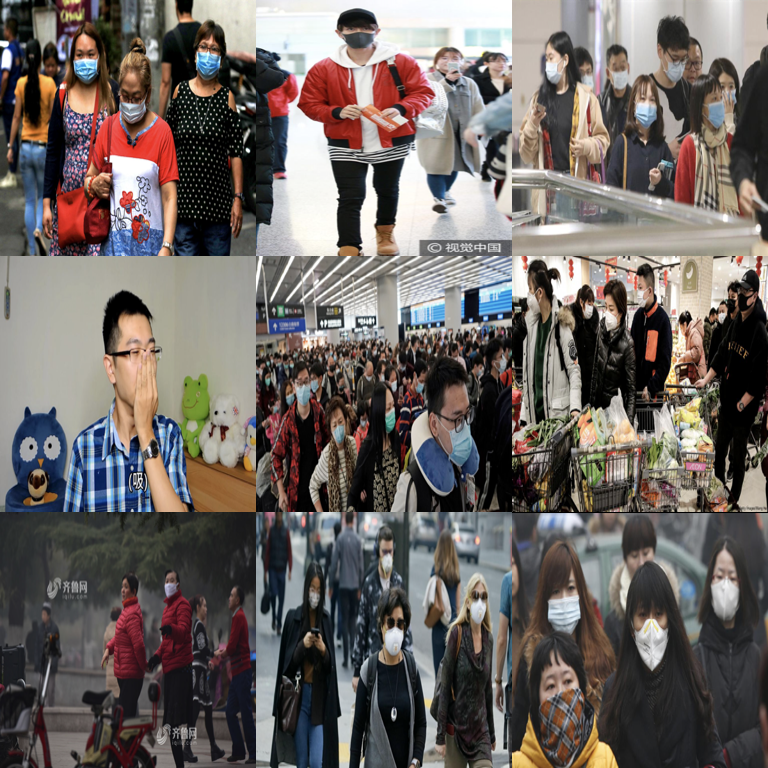

In [32]:



# Define the path to the test images directory
test_images_dir = 'yolov8/test/images'

# List all PNG image files in the directory
image_files = [f for f in os.listdir(test_images_dir) 
               if os.path.isfile(os.path.join(test_images_dir, f)) 
               and f.lower().endswith('.png')]

# Ensure there are enough images
num_images = min(16, len(image_files))

# Load and resize images
images = []
for i in range(num_images):
    img_path = os.path.join(test_images_dir, image_files[i])
    img = Image.open(img_path)
    img = img.resize((256, 256))  # Resize images to a common size (optional)
    images.append(img)

# Create a blank canvas to hold the grid of images
grid_size = 3
canvas_width = canvas_height = grid_size * 256
canvas = Image.new('RGB', (canvas_width, canvas_height))

# Paste images onto the canvas
for i in range(grid_size):
    for j in range(grid_size):
        if i * grid_size + j < num_images:
            img = images[i * grid_size + j]
            canvas.paste(img, (j * 256, i * 256))

# Display the combined image
from IPython.display import display
display(canvas)


In [ ]:

test_images_dir = 'yolov8/test/images'
output_dir = 'yolov8/test/outputs'  # Directory to save 

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# Load the YOLO model
model = YOLO('runs/detect/train10/weights/best.pt')

# List all PNG image files in the directory
image_files = [f for f in os.listdir(test_images_dir) 
               if os.path.isfile(os.path.join(test_images_dir, f)) 
               and f.lower().endswith('.png')]

# Process each image file
for image_file in image_files:
    img_path = os.path.join(test_images_dir, image_file)
    results = model.predict(source=img_path, conf=0.3, device='0')
    # Save the detection result
    output_image_path = os.path.join(output_dir, image_file)
    results[0].save(output_image_path)



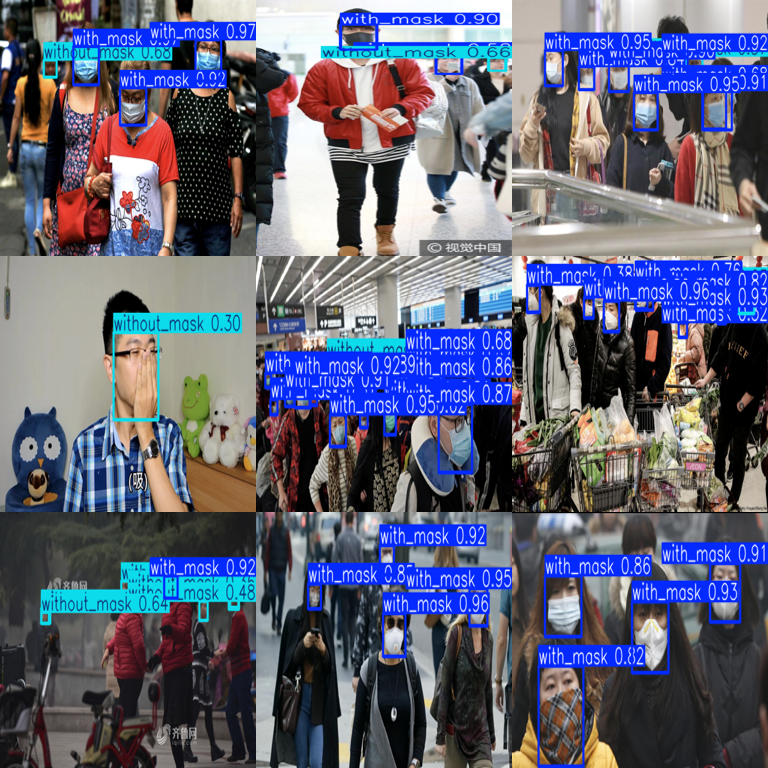

In [31]:
# Create a grid of the resulting images
def create_image_grid(image_paths, grid_size=(4, 4), image_size=(256, 256)):
   
    canvas_width = grid_size[1] * image_size[0]
    canvas_height = grid_size[0] * image_size[1]
    canvas = Image.new('RGB', (canvas_width, canvas_height))

    
    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            index = i * grid_size[1] + j
            if index < len(image_paths):
                img = Image.open(image_paths[index])
                img = img.resize(image_size)  # Resize images to fit in grid
                canvas.paste(img, (j * image_size[0], i * image_size[1]))

    return canvas


result_image_files = [os.path.join(output_dir, f) for f in image_files]
num_images = min(16, len(result_image_files))  # Limit to 9 images

# Create and display the image grid
grid_image = create_image_grid(result_image_files[:num_images], grid_size=(3, 3))
display(grid_image)
